# Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data as torch_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from typing import Final
import pandas as pd
import dataclasses
from etils import epath
import torch_scatter
import gc
from tqdm.notebook import tqdm
from graphmodels import featurizer
from graphmodels import constants
from graphmodels import datasets
from graphmodels import data_utils
from graphmodels import models
from graphmodels.layers import graph_attention_layers
from torch.utils.data import DataLoader, Dataset
from sklearn import model_selection as sk_modelselection
from sklearn import metrics as sk_metrics

from torch_geometric.loader import DataLoader as GeomDataLoader


from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
print(torch.cuda.is_available())

True


In [2]:
# DATAPATH: epath.Path = epath.Path("../datasets/chemistry/")
# df = pd.read_csv(DATAPATH/"delaney-processed_clean.csv")
# df["mol"] = df["RDKIT_SMILES"].apply(Chem.MolFromSmiles)
# df["num_bonds"] = df["mol"].apply(lambda x : x.GetNumBonds())
# df = df.loc[df["num_bonds"]>=1]

In [3]:
# # Split data
# train_df, test_df = sk_modelselection.train_test_split(
#     df, test_size=0.3, random_state=42, shuffle=True,
#     #stratify=df["measured log solubility in mols per litre"]
# )
# train_df, valid_df = sk_modelselection.train_test_split(
#     train_df,
#     test_size=0.15,
#     random_state=42,
#     shuffle=True,
#     #stratify=train_df["measured log solubility in mols per litre"],
# )

In [4]:
# LABEL: str = "measured log solubility in mols per litre"
# SMILES: str = "smiles"
# train_dset = datasets.mpnn_dataset.MPNNDataset(smiles=tuple(train_df[SMILES]),
#                                                targets=tuple(train_df[LABEL]),
#                                  add_master_node=False)

# valid_dset = datasets.mpnn_dataset.MPNNDataset(smiles=tuple(valid_df[SMILES]),
#                                                targets=tuple(valid_df[LABEL]),
#                                  add_master_node=False)

# test_dset = datasets.mpnn_dataset.MPNNDataset(smiles=tuple(test_df[SMILES]),
#                                                targets=tuple(test_df[LABEL]),
#                                 add_master_node=False)


# train_dataloader = DataLoader(dataset=train_dset,
#                               batch_size=32,
#                               shuffle=True,
#                               collate_fn=data_utils.mpnn_collate_diag,
#                              )

# valid_dataloader = DataLoader(dataset=valid_dset,
#                               batch_size=32,
#                               shuffle=False,
#                               collate_fn=data_utils.mpnn_collate_diag,
#                              )

# test_dataloader = DataLoader(dataset=test_dset,
#                               batch_size=32,
#                               shuffle=False,
#                               collate_fn=data_utils.mpnn_collate_diag,
#                             )

from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')

# Extract labels for stratified splitting
labels = [data.y.item() for data in dataset]

# First split: train vs temp (val + test)
train_idx, temp_idx = sk_modelselection.train_test_split(
    list(range(len(dataset))),
    test_size=0.3,
    stratify=labels,
    random_state=42,
)

# Second split: val vs test from temp
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = sk_modelselection.train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42,
)

# Create the datasets
train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
test_dataset = dataset[test_idx]

# Create data loaders
train_loader = GeomDataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = GeomDataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = GeomDataLoader(test_dataset, batch_size=32, shuffle=False)

Processing...
Done!


In [5]:

class GraphAttentionLayerV4(nn.Module):
    """Updated graph attention layer with edge features and skip connections

    Attributes
        n_node_features: number of input node features.
        n_hidden_features: number of hidden features in intermediate layers.
        scaling: scaling constant for LeakyRelu
    """

    def __init__(
        self,
        n_node_features: int,
        n_edge_features: int,
        n_hidden_features: int,
        scaling: float = 0.2,
        dropout: float = 0.25,
    ):
        super().__init__()
        self.scaling = scaling
        self.dropout = dropout
        self.w = nn.Linear(n_node_features, n_hidden_features)
        self.edgew = nn.Linear(n_edge_features, n_hidden_features)
        self.attn = nn.Linear(n_hidden_features * 3, 1)

    def compute_attention(
        self,
        node_features: torch.Tensor,
        edge_features: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:
        """Computes attention score between nodes i and j.

        The attention mechanism is defined as:

            α_ij = softmax_j( LeakyReLU( aᵀ [ W h_i || W h_j ] ) )

        where:
        - h_i, h_j are the input features of nodes i and j,
        - W is a shared learnable weight matrix,
        - a is a learnable attention vector,
        - || denotes vector concatenation,
        - softmax_j is applied over all neighbors j ∈ N(i) of node i.

        The updated feature for node i is computed as:

            h_i' = σ( Σ_{j ∈ N(i)} α_ij · W h_j )

        where σ is a non-linear activation function.

        Args:
            node_features: Input node features.
            edge_features: Input edge features.
            edge_index: Graph connectivity in COO format with shape $(2, E)$,
            where $E$ is the number of edges.

        Returns:
            Attention scores multiplied by transformed neighbor features,
            transformed node features, and target node indices.
        """

        h = F.leaky_relu(self.w(node_features), self.scaling)
        edge_h = F.leaky_relu(self.edgew(edge_features), self.scaling)

        neighbors_nodes = edge_index[1]
        target_nodes = edge_index[0]

        h_i = h[target_nodes]
        h_j = h[neighbors_nodes]
        h_concat = torch.cat([h_i, h_j, edge_h], dim=-1)

        eij = self.attn(h_concat)

        attention_score = F.dropout(
            torch_scatter.scatter_softmax(
                src=eij,
                index=target_nodes,
                dim=0,
            ),
            p=self.dropout,
        )
        message = attention_score * h_j
        return message, h, target_nodes

    def forward(
        self,
        node_features: torch.Tensor,
        edge_features: torch.Tensor,
        edge_index: torch.Tensor,
    ):
        message, transformed_node_features, target_nodes = self.compute_attention(
            node_features=node_features,
            edge_features=edge_features,
            edge_index=edge_index,
        )

        out = torch_scatter.scatter_add(
            message,
            target_nodes,
            dim=0,
            dim_size=node_features.size(0),
        )
        out = out + transformed_node_features
        return F.elu(out)
    
class GraphAttentionLayerV3(nn.Module):
    """Implements a graph attention layer with skip connection.
    
    After the aggregation step, we add the transformed node features
    to the aggregated node features.

    Attributes
        n_node_features: number of input node features.
        n_hidden_features: number of hidden features in intermediate layers.
        scaling: scaling constant for LeakyRelu
    """

    def __init__(
        self,
        n_node_features: int,
        n_hidden_features: int,
        scaling: float = 0.2,
        dropout: float = 0.25,
    ):
        super().__init__()
        self.scaling = scaling
        self.dropout = dropout
        self.w = nn.Linear(n_node_features, n_hidden_features)
        self.attn = nn.Linear(n_hidden_features * 2, 1)
        self.norm = nn.LayerNorm(n_hidden_features)

    def compute_attention(
        self,
        node_features: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:
        """Computes attention score between nodes i and j.

        The attention mechanism is defined as:

            α_ij = softmax_j( LeakyReLU( aᵀ [ W h_i || W h_j ] ) )

        where:
        - h_i, h_j are the input features of nodes i and j,
        - W is a shared learnable weight matrix,
        - a is a learnable attention vector,
        - || denotes vector concatenation,
        - softmax_j is applied over all neighbors j ∈ N(i) of node i.

        The updated feature for node i is computed as:

            h_i' = σ( Σ_{j ∈ N(i)} α_ij · W h_j )

        where σ is a non-linear activation function (e.g., ELU or ReLU).

        Args:
            node_features: input node features (shape = N, F)
            where N is the number of nodes and F the number of features.
            edge_index: graph connectivity in COO format with shape (2, E),
                where E is the number of edges. The first row contains target
                node indices, and the second row contains source node indices.
        Returns:
            Attention scores for nodes.
        """

        h = F.elu(self.w(node_features))

        neighbors_nodes = edge_index[1]
        target_nodes = edge_index[0]

        h_i = h[target_nodes]

        h_j = h[neighbors_nodes]
        h_concat = torch.cat([h_i, h_j], dim=-1)

        eij = self.attn(h_concat)

        attention_score = F.dropout(
            torch_scatter.scatter_softmax(
                src=eij,
                index=target_nodes,
                dim=0,
            ),
            p=self.dropout,
        )
        message = (attention_score * h_j)
        
        return message, h, target_nodes

    def forward(
        self,
        node_features: torch.Tensor,
        edge_index: torch.Tensor,
    ):
        message, transformed_node_features, target_nodes = self.compute_attention(
            node_features=node_features,
            edge_index=edge_index,
        )
        out = torch_scatter.scatter_add(
            message,
            target_nodes,
            dim=0,
            dim_size=transformed_node_features.size(0),
        )
        out = out + transformed_node_features
        return self.norm(F.elu(out))

class MultiHeadGATLayer(nn.Module):
    """Implements a simple graph attention layer.

    Attributes
        n_node_features: number of input node features.
        n_hidden_features: number of hidden features in intermediate layers.
        scaling: scaling constant for LeakyRelu
    """

    def __init__(
        self,
        n_node_features: int,
        n_hidden_features: int,
        dropout: float,
        scaling: float = 0.2,
        num_heads: int = 8,
        agg_method: str = "mean",
    ):
        super().__init__()

        if agg_method not in ["mean", "concat", "max"]:
            raise ValueError("Only mean, max and concat are available.")
        self.num_heads = num_heads
        self.agg_method = agg_method
        self.head_dimension = n_hidden_features // num_heads

        self.scaling = scaling
        self.n_hidden_features = n_hidden_features

        attention_heads = [
            GraphAttentionLayerV3(
                n_node_features=n_node_features,
                n_hidden_features=self.head_dimension,
                dropout=dropout,
            )
        ]
        for i in range(1, self.num_heads):
            attention_heads.append(
                GraphAttentionLayerV3(
                    n_node_features=n_node_features,
                    n_hidden_features=self.head_dimension,
                    dropout=dropout,
                )
            )
        self.multiheadgat = nn.ModuleList(attention_heads)

        if agg_method in ["max", "mean"]:
            self.out_layer = nn.Linear(
                self.head_dimension, self.n_hidden_features
            )
        else:
            self.out_layer = nn.Identity()

    def forward(self, node_features, edge_index):
        head_outs = [
            attn_head(node_features, edge_index)
            for attn_head in self.multiheadgat
        ]
        if self.agg_method == "concat":
            return F.elu(self.out_layer(torch.cat(head_outs, dim=-1)))
        elif self.agg_method == "mean":
            return F.elu(self.out_layer(torch.mean(torch.stack(head_outs), dim=0)))

class MultiHeadGATLayerEdge(nn.Module):
    """Implements a simple graph attention layer.

    Attributes
        n_node_features: number of input node features.
        n_hidden_features: number of hidden features in intermediate layers.
        scaling: scaling constant for LeakyRelu
    """

    def __init__(
        self,
        n_node_features: int,
        n_edge_features: int,
        n_hidden_features: int,
        dropout: float,
        scaling: float = 0.2,
        num_heads: int = 8,
        agg_method: str = "mean",
    ):
        super().__init__()

        if agg_method not in ["mean", "concat", "max"]:
            raise ValueError("Only mean, max and concat are available.")
        self.num_heads = num_heads
        self.agg_method = agg_method
        self.head_dimension = n_hidden_features // num_heads

        self.scaling = scaling
        self.n_hidden_features = n_hidden_features

        attention_heads = [
            GraphAttentionLayerV4(
                n_node_features=n_node_features,
                n_edge_features=n_edge_features,
                n_hidden_features=self.head_dimension,
                dropout=dropout,
            )
        ]
        for i in range(1, self.num_heads):
            attention_heads.append(
                GraphAttentionLayerV4(
                    n_node_features=n_node_features,
                    n_edge_features=n_edge_features,
                    n_hidden_features=self.head_dimension,
                    dropout=dropout,
                )
            )
        self.multiheadgat = nn.ModuleList(attention_heads)

        if agg_method in ["max", "mean"]:
            self.out_layer = nn.Linear(
                self.head_dimension, self.n_hidden_features
            )
        else:
            self.out_layer = nn.Identity()

    def forward(self, node_features, edge_features, edge_index):
        head_outs = [
            attn_head(node_features, edge_features, edge_index)
            for attn_head in self.multiheadgat
        ]
        if self.agg_method == "concat":
            return F.elu(self.out_layer(torch.cat(head_outs, dim=-1)))
        elif self.agg_method == "mean":
            return F.elu(self.out_layer(torch.mean(torch.stack(head_outs), dim=0)))


In [6]:
class SimpleGATModel(nn.Module):
    """Implements a simple graph attention model."""
    def __init__(self, n_node_features: int, n_hidden_features: int, n_out_features: int, scaling: float=0.2, dropout: float=0.25):
        super().__init__()
        self.gat_layer1 = GraphAttentionLayerV3(n_node_features=n_node_features,
                                                n_hidden_features=n_hidden_features,
                                                scaling=scaling,
                                                dropout=dropout)
        self.gat_layer2 = GraphAttentionLayerV3(n_node_features=n_hidden_features,
                                                n_hidden_features=n_hidden_features,
                                                scaling=scaling,
                                                dropout=dropout)
        self.output_layer = nn.Linear(n_hidden_features, n_out_features)
        
    def forward(self, *, node_features, edge_index, batch_vector):
        
        out = self.gat_layer1(node_features=node_features, edge_index=edge_index)
        out = self.gat_layer2(node_features=out, edge_index=edge_index)
        
        num_batches = int(batch_vector.max()) + 1
        
        emb_dim = out.size(-1)
        
        mol_embeddings = torch.zeros(
            num_batches, emb_dim, device=out.device
        )

        mol_embeddings.index_add_(0, batch_vector, out)
        
        return self.output_layer(mol_embeddings)
        

class MultiheadGATModel(nn.Module):
    """Implements a simple graph attention model."""

    def __init__(
        self,
        n_node_features: int,
        *,
        n_hidden_features: int,
        n_out_features: int,
        num_heads: int,
        agg_method: str,
        dropout: float,
        scaling: float = 0.2,
    ):
        super().__init__()
        self.gat_layer1 = MultiHeadGATLayer(
            n_node_features=n_node_features,
            n_hidden_features=n_hidden_features,
            scaling=scaling,
            num_heads=num_heads,
            agg_method=agg_method,
            dropout=dropout,
        )

        self.output_layer = nn.Linear(n_hidden_features, n_out_features)

    def forward(self, node_features, edge_index, batch_vector):
        out = self.gat_layer1(node_features, edge_index)

        num_batches = int(batch_vector.max()) + 1

        emb_dim = out.size(-1)

        mol_embeddings = torch.zeros(num_batches, emb_dim, device=out.device)

        mol_embeddings.index_add_(0, batch_vector, out)

        return self.output_layer(mol_embeddings)


class MultiheadGATModelEdge(nn.Module):
    """Implements a simple graph attention model."""

    def __init__(
        self,
        n_node_features: int,
        n_edge_features: int,
        n_hidden_features: int,
        n_out_features: int,
        num_heads: int,
        agg_method: str,
        dropout: float,
        scaling: float = 0.2,
    ):
        super().__init__()
        self.gat_layer1 = MultiHeadGATLayerEdge(
            n_node_features=n_node_features,
            n_hidden_features=n_hidden_features,
            n_edge_features=n_edge_features,
            scaling=scaling,
            num_heads=num_heads,
            agg_method=agg_method,
            dropout=dropout,
        )

        self.output_layer = nn.Linear(n_hidden_features, n_out_features)

    def forward(self, node_features, edge_features, edge_index, batch_vector):
        out = self.gat_layer1(node_features, edge_features, edge_index)

        num_batches = int(batch_vector.max()) + 1

        emb_dim = out.size(-1)

        mol_embeddings = torch.zeros(num_batches, emb_dim, device=out.device)

        mol_embeddings.index_add_(0, batch_vector, out)

        return self.output_layer(mol_embeddings)


In [7]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                valid_loader: DataLoader,
                loss_fn: torch.nn.modules.loss,
                epochs: int=10,
                lr: float=1e-3,
                weight_decay: float=0.1,
                device: str='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    history = []

    model.to(device)
    print("🚀 Starting training...\n")
    pbar = tqdm(total=epochs, desc="Training")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            atom_feats = batch.x.to(device)
            #bond_features =  batch.edge_features.to(device)
            edge_index = batch.edge_index.to(device)
            labels = batch.y.to(device)
            batch_vector = batch.batch.to(device)

            optimizer.zero_grad()
            outputs = model(node_features=atom_feats, edge_index=edge_index, batch_vector=batch_vector).squeeze()

            loss = loss_fn(outputs, labels.squeeze().to(torch.float32))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch in valid_loader:
                atom_feats = batch.x.to(device)
                #bond_features =  batch.edge_features.to(device)
                edge_index = batch.edge_index.to(device)
                labels = batch.y.to(device)
                batch_vector = batch.batch.to(device)

                outputs = model(node_features=atom_feats, edge_index=edge_index, batch_vector=batch_vector).squeeze()
                loss = loss_fn(outputs, labels.squeeze().to(torch.float32))
                valid_loss += loss.item()
        valid_loss /= len(valid_loader)

        # Update the tqdm progress bar with train and validation loss
        pbar.set_postfix({"train_loss": f"{train_loss:.4f}", "val_loss": f"{valid_loss:.4f}"})

        history.append({'epoch': epoch+1, 'train_loss': train_loss, 'valid_loss': valid_loss})
        pbar.update(1)

    pbar.close()
    print("\n🎉 Training completed!\n")
    return pd.DataFrame(history)


In [18]:
gat_model = MultiheadGATModel(n_node_features=3,
                                  n_hidden_features=8,
                                  n_out_features=1,
                                  dropout=0.0,
                                  agg_method="concat",
                                  num_heads=2)
#gat_model = SimpleGATModel(n_node_features=3, n_hidden_features=24, n_out_features=1, dropout=0.25)
history = train_model(model=gat_model,
                      loss_fn=nn.BCEWithLogitsLoss(),
                      train_loader=train_loader,
                      valid_loader=val_loader,
                      epochs=200,
                      lr=1e-3,
                      weight_decay=1e-5,
                      device="cuda")

gc.collect()
torch.cuda.empty_cache()

🚀 Starting training...



Training:   0%|          | 0/200 [00:00<?, ?it/s]


🎉 Training completed!



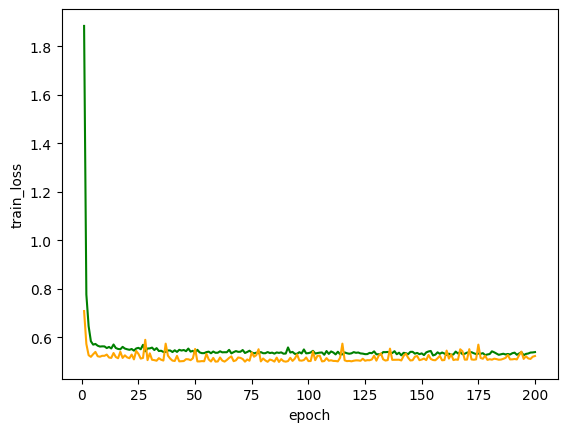

In [19]:
ax = sns.lineplot(history, x="epoch", y="train_loss",color="green")
ax = sns.lineplot(history, x="epoch", y="valid_loss", color="orange")

In [20]:
gat_model.eval()
device="cpu"
gat_model.to(device)

preds = []
target_labels = []
with torch.no_grad():
    for batch in test_loader:
        
        atom_feats = batch.x.to(device)
        #bond_features =  batch.edge_features.to(device)
        edge_index = batch.edge_index.to(device)
        labels = batch.y.to(device)
        batch_vector = batch.batch.to(device)

        outputs = gat_model(node_features=atom_feats, edge_index=edge_index, batch_vector=batch_vector).squeeze()
        probs = torch.sigmoid(outputs)
        preds.append((probs >= 0.5).int())
        target_labels.append(labels)

preds = torch.cat(preds)
target_labels = torch.cat(target_labels)

In [21]:
mcc = sk_metrics.matthews_corrcoef(target_labels, preds)
acc = sk_metrics.accuracy_score(target_labels, preds)
mcc,acc

(0.3235032608491716, 0.6706586826347305)

In [22]:
sk_metrics.confusion_matrix(target_labels, preds)

array([[70, 30],
       [25, 42]])